In [1]:
import sys
import os
#from source.utils import load_net, load_weights, dino_test_collate
import torch, torchvision
from utils import *
import matplotlib.pyplot as plt
import pandas as pd
from dataset import *
from torch.utils.data import Subset, random_split
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
#from sklearn.decomposition import PCA
import seaborn as sb
from sklearn.manifold import TSNE
import umap
from backbone.backbone_main import load_backbone_

config = load_yaml("/homes/nmorelli/aibio_nico/config/general_conf.yaml")
device = load_device(config)
dataset = Rxrx1(root_dir=config["dataset_dir"], metadata_path=config["metadata_path"])

# net, loss_func, opt, sched = config_loader(config, dataset)
# if config["load_backbone"] is not None:
#     net = load_backbone_(net, config)

+--------------------+---------------------------------------------------------------------------+
|               Name |                                                                     Value |
+--------------------+---------------------------------------------------------------------------+
|                net |                                                                    simclr |
|      backbone_name |                                                                 vit_small |
|     checkpoint_dir |                                     /homes/nmorelli/aibio_nico/checkpoint |
|        dataset_dir |                                                    /work/ai4bio2024/rxrx1 |
|    load_checkpoint |                                                                      None |
|      load_backbone |                                                                      None |
|      metadata_path | /work/h2020deciderficarra_shared/rxrx1/metadata/m_3c_experiment_strat.csv |
|         

In [2]:
def plot_embeddings(net: nn.Module, dataset):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True,
                                            num_workers=8, drop_last=True, prefetch_factor=8, persistent_workers=True,collate_fn=None, pin_memory=True)

    embeddings = []
    labels = []
    net = net.to(device)
    net.eval()
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = images.to(device)
            features = net.get_embedding(images)
            features = features.view(features.size(0), -1) 
            embeddings.append(features.cpu().numpy())
            labels.extend(targets.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="jet", alpha=0.7)
    plt.colorbar(scatter, label="Class Labels")
    plt.title("t-SNE Visualization of Embeddings")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()

def plot_embeddings_2(net: nn.Module, dataset: torch.utils.data.Subset):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True,
                                            num_workers=8, drop_last=True, prefetch_factor=8, persistent_workers=True, pin_memory=True)

    embeddings = []
    labels = []
    net = net.to(device)
    net.eval()
    with torch.no_grad():
        for images, targets, meta in tqdm(dataloader):
            images = images.to(device)
            features = net.get_embedding(images)
            features = features.view(features.size(0), -1) 
            embeddings.append(features.cpu().numpy())
            # labels.extend(targets.numpy())
            # labels.extend(torch.tensor(meta[dataset.dataset.cell_type_idx]).numpy())
            labels.extend(torch.tensor(meta[dataset.dataset.experiment_idx]).numpy())

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="jet", alpha=0.7)
    plt.colorbar(scatter, label="Class Labels")
    plt.title("t-SNE Visualization of Embeddings")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()

In [3]:
_, test_split = random_split(dataset, [0.95, 0.05])
len(test_split)

6275

  0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipykernel_1280934/1161289337.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.extend(torch.tensor(meta[dataset.dataset.experiment_idx]).numpy())
100%|██████████| 39/39 [00:12<00:00,  3.10it/s]


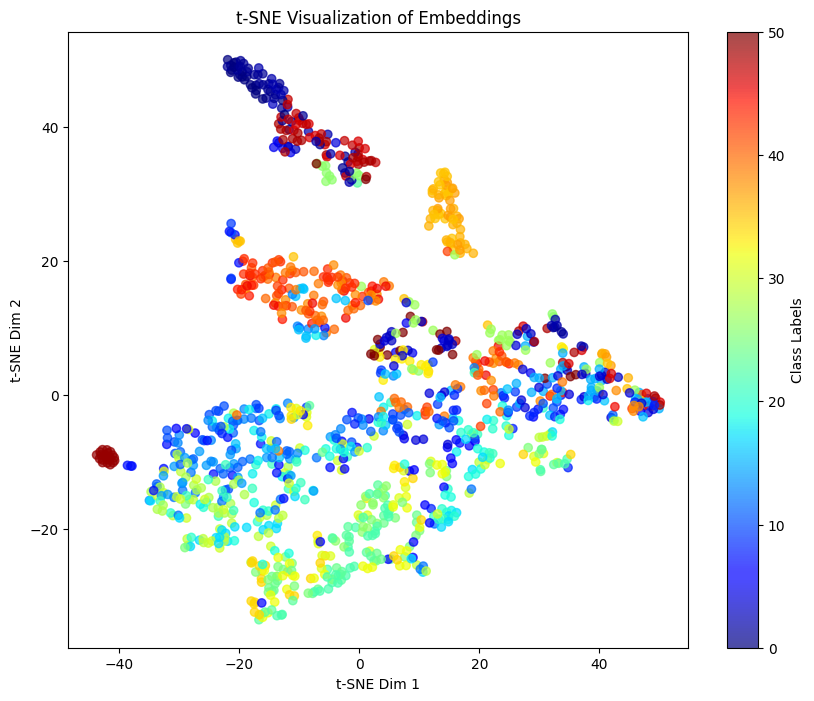

In [4]:
checkpoint = torch.load("/homes/nmorelli/aibio_nico/checkpoint/vit_small_back")
net2, loss_func, opt, sched = config_loader(config, dataset)
# net2 = nn.DataParallel(net2)
net2.load_state_dict(checkpoint["model_state_dict"], strict=False)
net2.eval()
plot_embeddings_2(net2, test_split)


In [8]:
checkpoint = torch.load("/homes/nmorelli/aibio_nico/checkpoint/vit_small_back_test_2")
net2, loss_func, opt, sched = config_loader(config, dataset)
# net2.load_state_dict(checkpoint["model_state_dict"], strict=False)
net2.eval()
# plot_embeddings_2(net2, test_split)


SimCLR(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm

In [4]:
checkpoint = torch.load("/homes/nmorelli/tesi_prj/checkpoint/rn18_scratch_pretrain_loaded_fold0")
net, loss_func, opt, sched = config_loader(config, dataset)
net.load_state_dict(checkpoint["model_state_dict"])
net.eval()
plot_embeddings_2(net, dataset)


RuntimeError: Error(s) in loading state_dict for SimCLR:
	Missing key(s) in state_dict: "backbone.cls_token", "backbone.pos_embed", "backbone.patch_embed.proj.weight", "backbone.patch_embed.proj.bias", "backbone.blocks.0.norm1.weight", "backbone.blocks.0.norm1.bias", "backbone.blocks.0.attn.qkv.weight", "backbone.blocks.0.attn.qkv.bias", "backbone.blocks.0.attn.proj.weight", "backbone.blocks.0.attn.proj.bias", "backbone.blocks.0.norm2.weight", "backbone.blocks.0.norm2.bias", "backbone.blocks.0.mlp.fc1.weight", "backbone.blocks.0.mlp.fc1.bias", "backbone.blocks.0.mlp.fc2.weight", "backbone.blocks.0.mlp.fc2.bias", "backbone.blocks.1.norm1.weight", "backbone.blocks.1.norm1.bias", "backbone.blocks.1.attn.qkv.weight", "backbone.blocks.1.attn.qkv.bias", "backbone.blocks.1.attn.proj.weight", "backbone.blocks.1.attn.proj.bias", "backbone.blocks.1.norm2.weight", "backbone.blocks.1.norm2.bias", "backbone.blocks.1.mlp.fc1.weight", "backbone.blocks.1.mlp.fc1.bias", "backbone.blocks.1.mlp.fc2.weight", "backbone.blocks.1.mlp.fc2.bias", "backbone.blocks.2.norm1.weight", "backbone.blocks.2.norm1.bias", "backbone.blocks.2.attn.qkv.weight", "backbone.blocks.2.attn.qkv.bias", "backbone.blocks.2.attn.proj.weight", "backbone.blocks.2.attn.proj.bias", "backbone.blocks.2.norm2.weight", "backbone.blocks.2.norm2.bias", "backbone.blocks.2.mlp.fc1.weight", "backbone.blocks.2.mlp.fc1.bias", "backbone.blocks.2.mlp.fc2.weight", "backbone.blocks.2.mlp.fc2.bias", "backbone.blocks.3.norm1.weight", "backbone.blocks.3.norm1.bias", "backbone.blocks.3.attn.qkv.weight", "backbone.blocks.3.attn.qkv.bias", "backbone.blocks.3.attn.proj.weight", "backbone.blocks.3.attn.proj.bias", "backbone.blocks.3.norm2.weight", "backbone.blocks.3.norm2.bias", "backbone.blocks.3.mlp.fc1.weight", "backbone.blocks.3.mlp.fc1.bias", "backbone.blocks.3.mlp.fc2.weight", "backbone.blocks.3.mlp.fc2.bias", "backbone.blocks.4.norm1.weight", "backbone.blocks.4.norm1.bias", "backbone.blocks.4.attn.qkv.weight", "backbone.blocks.4.attn.qkv.bias", "backbone.blocks.4.attn.proj.weight", "backbone.blocks.4.attn.proj.bias", "backbone.blocks.4.norm2.weight", "backbone.blocks.4.norm2.bias", "backbone.blocks.4.mlp.fc1.weight", "backbone.blocks.4.mlp.fc1.bias", "backbone.blocks.4.mlp.fc2.weight", "backbone.blocks.4.mlp.fc2.bias", "backbone.blocks.5.norm1.weight", "backbone.blocks.5.norm1.bias", "backbone.blocks.5.attn.qkv.weight", "backbone.blocks.5.attn.qkv.bias", "backbone.blocks.5.attn.proj.weight", "backbone.blocks.5.attn.proj.bias", "backbone.blocks.5.norm2.weight", "backbone.blocks.5.norm2.bias", "backbone.blocks.5.mlp.fc1.weight", "backbone.blocks.5.mlp.fc1.bias", "backbone.blocks.5.mlp.fc2.weight", "backbone.blocks.5.mlp.fc2.bias", "backbone.blocks.6.norm1.weight", "backbone.blocks.6.norm1.bias", "backbone.blocks.6.attn.qkv.weight", "backbone.blocks.6.attn.qkv.bias", "backbone.blocks.6.attn.proj.weight", "backbone.blocks.6.attn.proj.bias", "backbone.blocks.6.norm2.weight", "backbone.blocks.6.norm2.bias", "backbone.blocks.6.mlp.fc1.weight", "backbone.blocks.6.mlp.fc1.bias", "backbone.blocks.6.mlp.fc2.weight", "backbone.blocks.6.mlp.fc2.bias", "backbone.blocks.7.norm1.weight", "backbone.blocks.7.norm1.bias", "backbone.blocks.7.attn.qkv.weight", "backbone.blocks.7.attn.qkv.bias", "backbone.blocks.7.attn.proj.weight", "backbone.blocks.7.attn.proj.bias", "backbone.blocks.7.norm2.weight", "backbone.blocks.7.norm2.bias", "backbone.blocks.7.mlp.fc1.weight", "backbone.blocks.7.mlp.fc1.bias", "backbone.blocks.7.mlp.fc2.weight", "backbone.blocks.7.mlp.fc2.bias", "backbone.blocks.8.norm1.weight", "backbone.blocks.8.norm1.bias", "backbone.blocks.8.attn.qkv.weight", "backbone.blocks.8.attn.qkv.bias", "backbone.blocks.8.attn.proj.weight", "backbone.blocks.8.attn.proj.bias", "backbone.blocks.8.norm2.weight", "backbone.blocks.8.norm2.bias", "backbone.blocks.8.mlp.fc1.weight", "backbone.blocks.8.mlp.fc1.bias", "backbone.blocks.8.mlp.fc2.weight", "backbone.blocks.8.mlp.fc2.bias", "backbone.blocks.9.norm1.weight", "backbone.blocks.9.norm1.bias", "backbone.blocks.9.attn.qkv.weight", "backbone.blocks.9.attn.qkv.bias", "backbone.blocks.9.attn.proj.weight", "backbone.blocks.9.attn.proj.bias", "backbone.blocks.9.norm2.weight", "backbone.blocks.9.norm2.bias", "backbone.blocks.9.mlp.fc1.weight", "backbone.blocks.9.mlp.fc1.bias", "backbone.blocks.9.mlp.fc2.weight", "backbone.blocks.9.mlp.fc2.bias", "backbone.blocks.10.norm1.weight", "backbone.blocks.10.norm1.bias", "backbone.blocks.10.attn.qkv.weight", "backbone.blocks.10.attn.qkv.bias", "backbone.blocks.10.attn.proj.weight", "backbone.blocks.10.attn.proj.bias", "backbone.blocks.10.norm2.weight", "backbone.blocks.10.norm2.bias", "backbone.blocks.10.mlp.fc1.weight", "backbone.blocks.10.mlp.fc1.bias", "backbone.blocks.10.mlp.fc2.weight", "backbone.blocks.10.mlp.fc2.bias", "backbone.blocks.11.norm1.weight", "backbone.blocks.11.norm1.bias", "backbone.blocks.11.attn.qkv.weight", "backbone.blocks.11.attn.qkv.bias", "backbone.blocks.11.attn.proj.weight", "backbone.blocks.11.attn.proj.bias", "backbone.blocks.11.norm2.weight", "backbone.blocks.11.norm2.bias", "backbone.blocks.11.mlp.fc1.weight", "backbone.blocks.11.mlp.fc1.bias", "backbone.blocks.11.mlp.fc2.weight", "backbone.blocks.11.mlp.fc2.bias", "backbone.norm.weight", "backbone.norm.bias", "projection_head.0.weight", "projection_head.1.weight", "projection_head.1.bias", "projection_head.1.running_mean", "projection_head.1.running_var", "projection_head.4.weight", "projection_head.5.weight", "projection_head.5.bias", "projection_head.5.running_mean", "projection_head.5.running_var", "cls_head.0.weight", "cls_head.0.bias", "cls_head.2.weight", "cls_head.2.bias". 
	Unexpected key(s) in state_dict: "ll1.weight", "ll1.bias", "ll2.weight", "ll2.bias", "fc_head.0.weight", "fc_head.0.bias", "fc_head.2.weight", "fc_head.2.bias", "backbone.0.weight", "backbone.1.weight", "backbone.1.bias", "backbone.1.running_mean", "backbone.1.running_var", "backbone.1.num_batches_tracked", "backbone.4.0.conv1.weight", "backbone.4.0.bn1.weight", "backbone.4.0.bn1.bias", "backbone.4.0.bn1.running_mean", "backbone.4.0.bn1.running_var", "backbone.4.0.bn1.num_batches_tracked", "backbone.4.0.conv2.weight", "backbone.4.0.bn2.weight", "backbone.4.0.bn2.bias", "backbone.4.0.bn2.running_mean", "backbone.4.0.bn2.running_var", "backbone.4.0.bn2.num_batches_tracked", "backbone.4.1.conv1.weight", "backbone.4.1.bn1.weight", "backbone.4.1.bn1.bias", "backbone.4.1.bn1.running_mean", "backbone.4.1.bn1.running_var", "backbone.4.1.bn1.num_batches_tracked", "backbone.4.1.conv2.weight", "backbone.4.1.bn2.weight", "backbone.4.1.bn2.bias", "backbone.4.1.bn2.running_mean", "backbone.4.1.bn2.running_var", "backbone.4.1.bn2.num_batches_tracked", "backbone.5.0.conv1.weight", "backbone.5.0.bn1.weight", "backbone.5.0.bn1.bias", "backbone.5.0.bn1.running_mean", "backbone.5.0.bn1.running_var", "backbone.5.0.bn1.num_batches_tracked", "backbone.5.0.conv2.weight", "backbone.5.0.bn2.weight", "backbone.5.0.bn2.bias", "backbone.5.0.bn2.running_mean", "backbone.5.0.bn2.running_var", "backbone.5.0.bn2.num_batches_tracked", "backbone.5.0.downsample.0.weight", "backbone.5.0.downsample.1.weight", "backbone.5.0.downsample.1.bias", "backbone.5.0.downsample.1.running_mean", "backbone.5.0.downsample.1.running_var", "backbone.5.0.downsample.1.num_batches_tracked", "backbone.5.1.conv1.weight", "backbone.5.1.bn1.weight", "backbone.5.1.bn1.bias", "backbone.5.1.bn1.running_mean", "backbone.5.1.bn1.running_var", "backbone.5.1.bn1.num_batches_tracked", "backbone.5.1.conv2.weight", "backbone.5.1.bn2.weight", "backbone.5.1.bn2.bias", "backbone.5.1.bn2.running_mean", "backbone.5.1.bn2.running_var", "backbone.5.1.bn2.num_batches_tracked", "backbone.6.0.conv1.weight", "backbone.6.0.bn1.weight", "backbone.6.0.bn1.bias", "backbone.6.0.bn1.running_mean", "backbone.6.0.bn1.running_var", "backbone.6.0.bn1.num_batches_tracked", "backbone.6.0.conv2.weight", "backbone.6.0.bn2.weight", "backbone.6.0.bn2.bias", "backbone.6.0.bn2.running_mean", "backbone.6.0.bn2.running_var", "backbone.6.0.bn2.num_batches_tracked", "backbone.6.0.downsample.0.weight", "backbone.6.0.downsample.1.weight", "backbone.6.0.downsample.1.bias", "backbone.6.0.downsample.1.running_mean", "backbone.6.0.downsample.1.running_var", "backbone.6.0.downsample.1.num_batches_tracked", "backbone.6.1.conv1.weight", "backbone.6.1.bn1.weight", "backbone.6.1.bn1.bias", "backbone.6.1.bn1.running_mean", "backbone.6.1.bn1.running_var", "backbone.6.1.bn1.num_batches_tracked", "backbone.6.1.conv2.weight", "backbone.6.1.bn2.weight", "backbone.6.1.bn2.bias", "backbone.6.1.bn2.running_mean", "backbone.6.1.bn2.running_var", "backbone.6.1.bn2.num_batches_tracked", "backbone.7.0.conv1.weight", "backbone.7.0.bn1.weight", "backbone.7.0.bn1.bias", "backbone.7.0.bn1.running_mean", "backbone.7.0.bn1.running_var", "backbone.7.0.bn1.num_batches_tracked", "backbone.7.0.conv2.weight", "backbone.7.0.bn2.weight", "backbone.7.0.bn2.bias", "backbone.7.0.bn2.running_mean", "backbone.7.0.bn2.running_var", "backbone.7.0.bn2.num_batches_tracked", "backbone.7.0.downsample.0.weight", "backbone.7.0.downsample.1.weight", "backbone.7.0.downsample.1.bias", "backbone.7.0.downsample.1.running_mean", "backbone.7.0.downsample.1.running_var", "backbone.7.0.downsample.1.num_batches_tracked", "backbone.7.1.conv1.weight", "backbone.7.1.bn1.weight", "backbone.7.1.bn1.bias", "backbone.7.1.bn1.running_mean", "backbone.7.1.bn1.running_var", "backbone.7.1.bn1.num_batches_tracked", "backbone.7.1.conv2.weight", "backbone.7.1.bn2.weight", "backbone.7.1.bn2.bias", "backbone.7.1.bn2.running_mean", "backbone.7.1.bn2.running_var", "backbone.7.1.bn2.num_batches_tracked". 

In [5]:
import numpy as np

torch.serialization.add_safe_globals([np.core.multiarray.scalar])

In [6]:
checkpoint = torch.load("/work/h2020deciderficarra_shared/rxrx1/checkpoints/dino/custom_centering_2/checkpoint0095.pth", weights_only=False)
net, loss_func, opt, sched = config_loader(config, dataset)


In [7]:
state_dict = checkpoint["student"]
new_state_dict = {}

for k in state_dict.keys():
    # if "mlp" in k: continue
    # if "head" in k: continue

    new_k = k.removeprefix("module.")
    new_state_dict[new_k] = state_dict[k]
net.load_state_dict(new_state_dict, strict=False)


_IncompatibleKeys(missing_keys=['projection_head.0.weight', 'projection_head.1.weight', 'projection_head.1.bias', 'projection_head.1.running_mean', 'projection_head.1.running_var', 'projection_head.4.weight', 'projection_head.5.weight', 'projection_head.5.bias', 'projection_head.5.running_mean', 'projection_head.5.running_var', 'cls_head.0.weight', 'cls_head.0.bias', 'cls_head.2.weight', 'cls_head.2.bias'], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])

  0%|          | 0/196 [00:00<?, ?it/s]/tmp/ipykernel_1531530/2702418695.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.extend(torch.tensor(meta[dataset.dataset.cell_type_idx]).numpy())
100%|██████████| 196/196 [00:33<00:00,  5.94it/s]


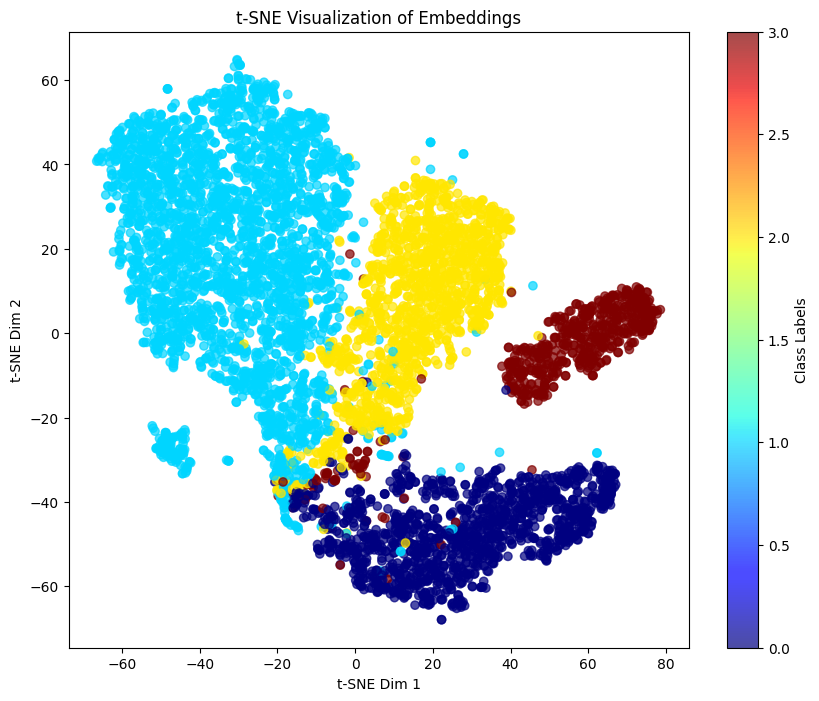

In [8]:
plot_embeddings_2(net, test_split)

  0%|          | 0/196 [00:00<?, ?it/s]

/tmp/ipykernel_1536106/2873778420.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.extend(torch.tensor(meta[dataset.dataset.experiment_idx]).numpy())
100%|██████████| 196/196 [00:30<00:00,  6.34it/s]


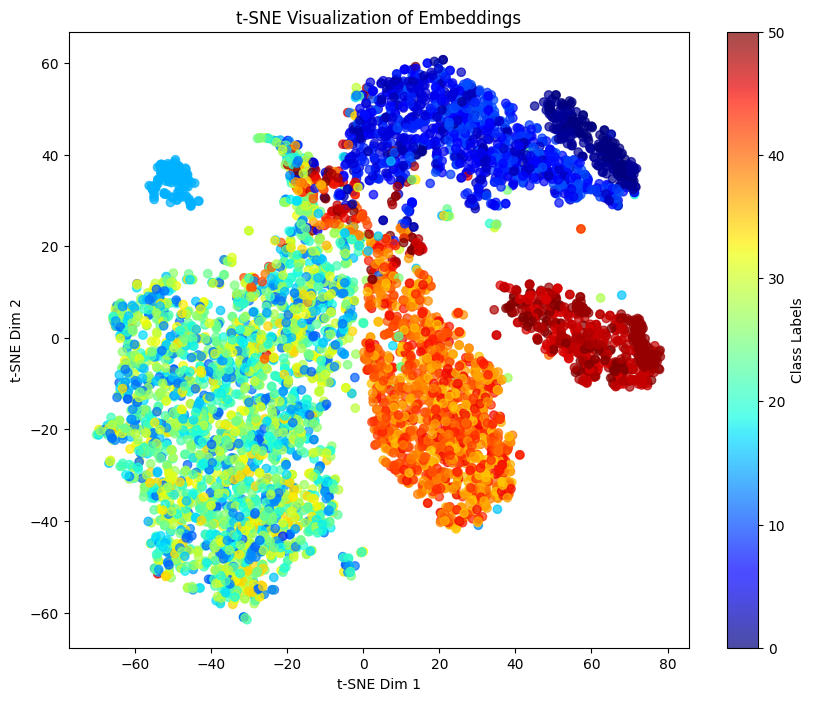

In [8]:
plot_embeddings_2(net, test_split)

In [9]:
checkpoint = torch.load("/homes/nmorelli/aibio_nico/checkpoint/vit_small_back")
net, loss_func, opt, sched = config_loader(config, dataset)
state_dict = {}
for k in checkpoint["model_state_dict"].keys():
    new_k = k.removeprefix("module.")
    state_dict[new_k] = checkpoint["model_state_dict"][k]

net.load_state_dict(state_dict)
net.eval()
plot_embeddings_2(net, test_split)


RuntimeError: Error(s) in loading state_dict for SimCLR:
	size mismatch for backbone.cls_token: copying a param with shape torch.Size([1, 1, 768]) from checkpoint, the shape in current model is torch.Size([1, 1, 384]).
	size mismatch for backbone.pos_embed: copying a param with shape torch.Size([1, 197, 768]) from checkpoint, the shape in current model is torch.Size([1, 197, 384]).
	size mismatch for backbone.patch_embed.proj.weight: copying a param with shape torch.Size([768, 3, 16, 16]) from checkpoint, the shape in current model is torch.Size([384, 3, 16, 16]).
	size mismatch for backbone.patch_embed.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.0.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.0.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.0.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.0.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.0.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.0.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.1.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.1.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.1.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.1.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.1.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.1.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.2.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.2.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.2.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.2.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.2.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.2.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.2.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.3.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.3.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.3.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.3.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.3.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.3.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.3.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.4.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.4.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.4.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.4.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.4.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.4.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.4.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.4.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.4.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.4.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.4.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.4.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.5.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.5.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.5.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.5.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.5.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.5.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.5.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.5.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.5.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.5.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.5.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.5.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.6.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.6.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.6.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.6.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.6.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.6.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.6.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.6.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.6.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.6.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.6.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.6.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.7.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.7.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.7.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.7.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.7.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.7.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.7.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.7.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.7.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.7.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.7.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.7.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.8.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.8.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.8.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.8.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.8.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.8.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.8.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.8.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.8.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.8.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.8.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.8.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.9.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.9.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.9.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.9.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.9.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.9.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.9.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.9.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.9.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.9.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.9.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.9.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.10.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.10.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.10.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.10.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.10.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.10.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.10.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.10.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.10.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.10.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.10.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.10.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.11.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.11.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.11.attn.qkv.weight: copying a param with shape torch.Size([2304, 768]) from checkpoint, the shape in current model is torch.Size([1152, 384]).
	size mismatch for backbone.blocks.11.attn.qkv.bias: copying a param with shape torch.Size([2304]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for backbone.blocks.11.attn.proj.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for backbone.blocks.11.attn.proj.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.11.norm2.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.11.norm2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.blocks.11.mlp.fc1.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for backbone.blocks.11.mlp.fc1.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for backbone.blocks.11.mlp.fc2.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for backbone.blocks.11.mlp.fc2.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.norm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for backbone.norm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for projection_head.0.weight: copying a param with shape torch.Size([1536, 768]) from checkpoint, the shape in current model is torch.Size([768, 384]).
	size mismatch for projection_head.1.weight: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for projection_head.1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for projection_head.1.running_mean: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for projection_head.1.running_var: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for projection_head.4.weight: copying a param with shape torch.Size([256, 1536]) from checkpoint, the shape in current model is torch.Size([256, 768]).
	size mismatch for cls_head.0.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for cls_head.0.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for cls_head.2.weight: copying a param with shape torch.Size([4, 768]) from checkpoint, the shape in current model is torch.Size([4, 384]).

In [3]:
dataset[0]

(tensor([[[ 0.2703,  0.0878,  0.0878,  ..., -0.4595, -0.4595, -0.4595],
          [ 0.0878,  0.0878, -0.0946,  ..., -0.4595, -0.4595, -0.4595],
          [ 0.0878, -0.0946,  0.0878,  ..., -0.4595, -0.4595, -0.4595],
          ...,
          [-0.4595, -0.4595, -0.4595,  ..., -0.2771, -0.0946, -0.0946],
          [-0.4595, -0.4595, -0.4595,  ..., -0.0946, -0.0946, -0.0946],
          [-0.4595, -0.4595, -0.4595,  ..., -0.0946, -0.0946, -0.0946]],
 
         [[ 1.5553,  1.5553,  1.5553,  ..., -0.7354, -0.6718, -0.6718],
          [ 1.1735,  1.0462,  1.0462,  ..., -0.6718, -0.6718, -0.5445],
          [ 0.6008,  0.4099,  0.6645,  ..., -0.6718, -0.6718, -0.6082],
          ...,
          [-0.6082, -0.6082, -0.5445,  ...,  0.7917,  1.3008,  1.4917],
          [-0.5445, -0.5445, -0.6082,  ...,  1.0462,  1.6826,  1.8098],
          [-0.6082, -0.6082, -0.5445,  ...,  1.4917,  2.0007,  1.9371]],
 
         [[ 1.1949,  1.1949,  0.9241,  ..., -0.1591, -0.1591, -0.4300],
          [ 1.4657,  1.1949,